In [90]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV


from LoadData import load_data
import PlottingHelpers
import ProcessingHelpers

importlib.reload(ProcessingHelpers) # while still working on than fun
importlib.reload(PlottingHelpers) # while still working on than fun

<module 'PlottingHelpers' from '/home/jovyan/python-ml-turbofan/PlottingHelpers.py'>

In [3]:
sns.set() 

In [4]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [20]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Make a Column for the RUL data

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [21]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']


## Map the problem to a binary classification problem by mapping the RUL column to a binary colum by predicting a breakdown within the next 10 steps

In [22]:
df['FAILURE_NEAR'] = df['RUL'] < 10.0

## Drop the nan columns and rows

In [23]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 and col != 'FAILURE_NEAR' ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [24]:
df = df.drop(columns=cols_const + cols_nan)

## Normalize the dataset as shown in the Explorative_analysis notebook

In [25]:
df_start = df.loc[df['time'] < 10.0].copy()
cols_non_data = [col for col in df.columns if not col.startswith('sens')]
bias = df_start.mean()
scale = df_start.var()

bias[cols_non_data] = 0.0
scale[cols_non_data] = 1.0

df_n = (df - bias) / scale
#df_n = df.copy()

take out a certain percentage of units from the training data set for testing later, (additionally to the classic validation methods)


In [26]:
units = df_n['unit_nr'].unique()
n_units = len(df_n['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_n_test = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_test )].copy()
df_n_train = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_train )].copy()

In [27]:
df_n_train.describe()

,unit_nr,time,os_1,os_2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
count,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000,16627.000000
mean,52.254285,109.827509,-0.000008,0.000002,2.235318,0.177850,0.185770,-1.521098,13.012385,0.138216,6.299500,-1.991887,13.549391,0.108460,34.833154,0.743991,-7.176668,-11.426643,108.827509
std,29.427006,69.799182,0.002192,0.000293,3.539436,0.284363,0.258428,2.194515,23.333874,0.316850,8.531340,2.754622,23.329229,0.306977,52.709449,1.164597,10.459252,16.667925,69.799182
min,1.000000,1.000000,-0.008700,-0.000600,-8.286161,-0.735588,-0.588925,-10.253492,-52.250101,-0.480940,-16.070463,-12.185381,-57.379848,-0.543836,-132.009789,-3.206230,-46.306977,-72.250329,0.000000
25%,25.000000,52.000000,-0.001500,-0.000200,-0.326367,-0.018769,-0.001713,-2.899556,-2.638597,-0.036672,0.008933,-3.720292,-1.840424,-0.060410,-3.353698,-0.192541,-13.737842,-21.958038,51.000000
50%,54.000000,104.000000,0.000000,-0.000000,2.018929,0.159211,0.162556,-1.353983,10.591137,0.070357,5.475928,-1.763916,11.227676,0.052642,30.577578,0.560881,-6.177150,-10.167762,103.000000
75%,78.000000,158.000000,0.001500,0.000300,4.506365,0.357018,0.346457,0.066947,27.128306,0.196769,11.586098,0.041970,27.562801,0.179411,67.831293,1.314303,0.220359,0.431889,157.000000
max,100.000000,362.000000,0.007700,0.000600,15.308942,1.404371,1.026918,5.227167,166.040518,2.649302,37.956307,5.459627,164.777849,2.466147,235.437661,5.834836,28.718351,39.730231,361.000000


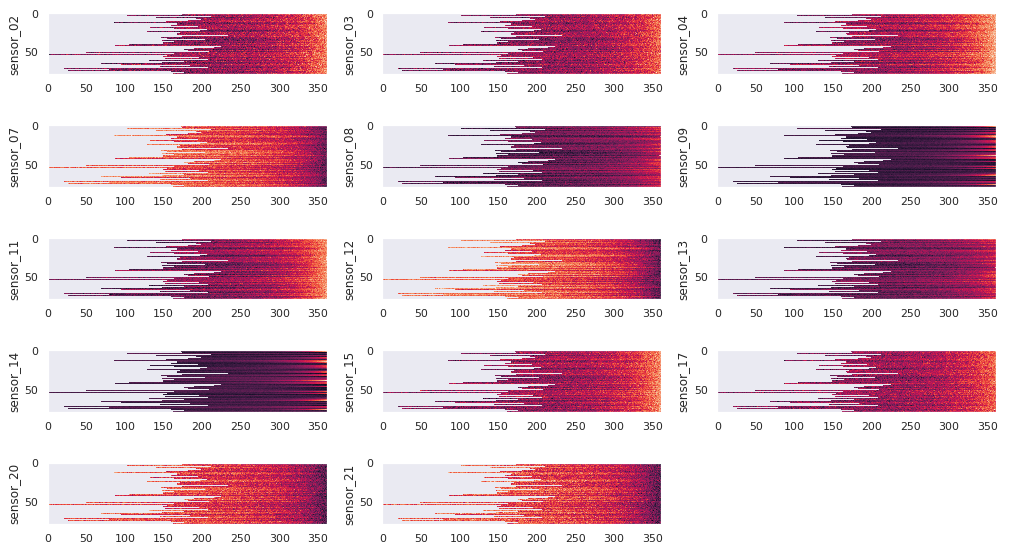

In [28]:
cols_features = [c for c in df_n_train.columns if c.startswith('o') or c.startswith('s')]

PlottingHelpers.plot_imshow(df_n_train, resample=False)

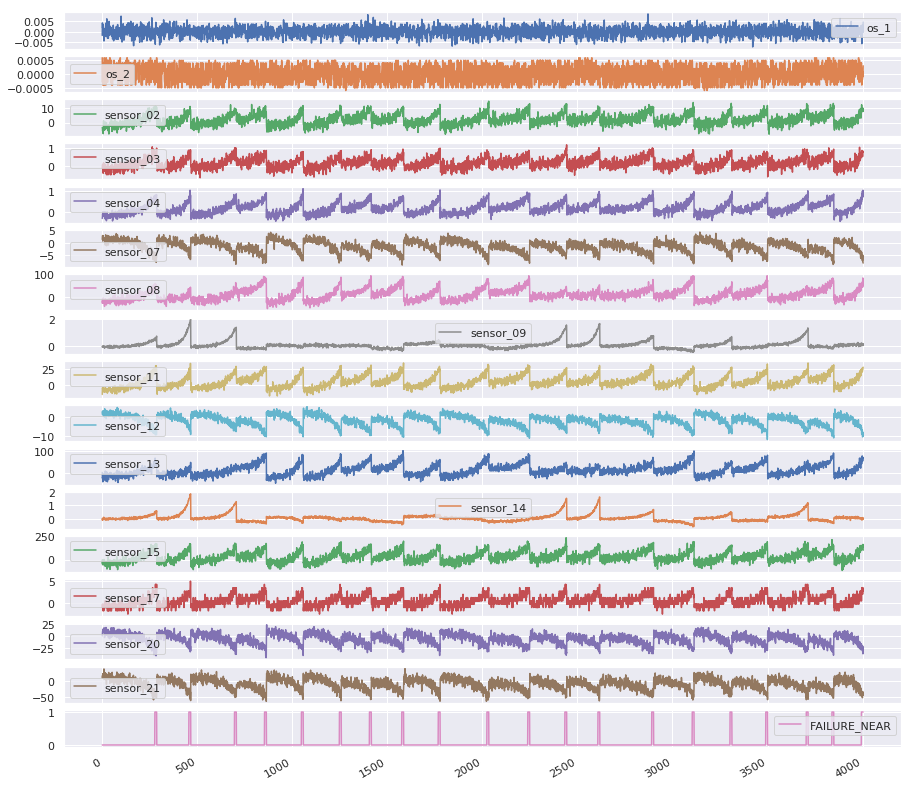

In [41]:
c = cols_features + ['FAILURE_NEAR']
t = pd.DataFrame(df_n_test[c].values, columns=c).plot(subplots=True, figsize=(15, 15))

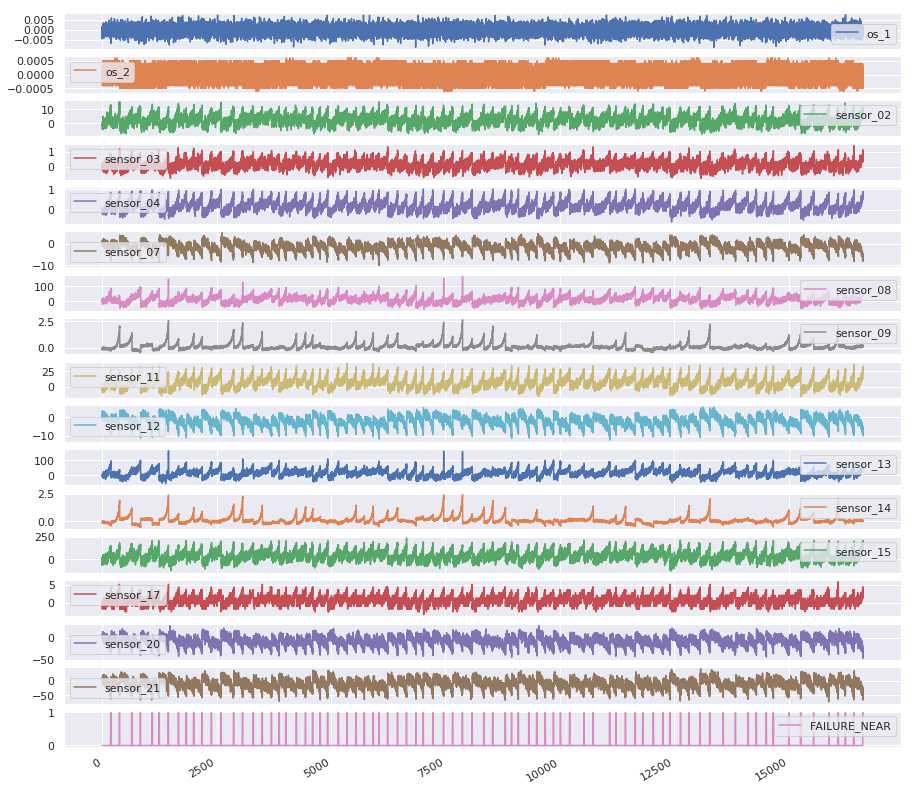

In [42]:
c = cols_features + ['FAILURE_NEAR']
t = pd.DataFrame(df_n_train[c].values, columns=c).plot(subplots=True, figsize=(15, 15))

## Do a simple support vector machine based classification on all training data

define a helper function for the simple fitting through a support vector machine

In [100]:
def fit_sub(df_n_train, df_n_test, mdl, cols_features):

    X_train = df_n_train[cols_features].values
    y_train = df_n_train['FAILURE_NEAR'].values > 0
    
    X_test = df_n_test[cols_features].values
    y_test = df_n_test['FAILURE_NEAR'].values > 0

    print(X_train.shape)
    if mdl is None:
        mdl = sk.pipeline.Pipeline([
            ('scaler', sk.preprocessing.MinMaxScaler()),
            ('regression', sk.svm.SVC(gamma='scale')),
        ])


    y_cv = sk.model_selection.cross_val_predict(
        mdl,
        X_train,
        y_train,
        cv=5
    )

    mdl.fit(X_train, y_train)
    y_test_p = mdl.predict(X_test) > 0

    print("cv test accuracy:       %s" % sk.metrics.accuracy_score(y_cv, y_train))
    print("testing units accuracy: %s" % sk.metrics.accuracy_score(y_test_p, y_test))

    res_full = {
        'dy_train_cv': np.logical_not(np.logical_and(y_cv, y_train)),
        'dy_test': np.logical_not(np.logical_and(y_test_p, y_test)),
        'y_train_p_cv': y_cv,
        'y_test_p': y_test_p,
    }
    
    return res_full

def fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None):
    
    if cols_features is None:
        cols_features = [c for c in df_n_train.columns if c.startswith('s')]
        
    res_full = fit_sub(df_n_train, df_n_test, mdl, cols_features)

    # Exclude the channels 14 and 9 since they are not generally falling or raising, 
    # and the channels 8,11,12,13,14 since they are highly correlating

    exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
    cols_features2 = [c for c in cols_features if c.startswith('s') and c not in exclude]

    res_red = fit_sub(df_n_train, df_n_test, mdl, cols_features2)
    
    return res_full, res_red


In [101]:
res = {}

In [102]:
res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None)
    
res['all_full'] = res_full
res['all_red'] = res_red

(16627, 14)
cv test accuracy:       0.983580922595778
testing units accuracy: 0.9857642357642358
(16627, 8)
cv test accuracy:       0.9773861791062729
testing units accuracy: 0.981018981018981


the model(s) seems to converge, and the accuracies look good. Lets take a look, how the classifications progress over the life cycle of each unit.

## Plot the progression of the predicted RULs over time:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


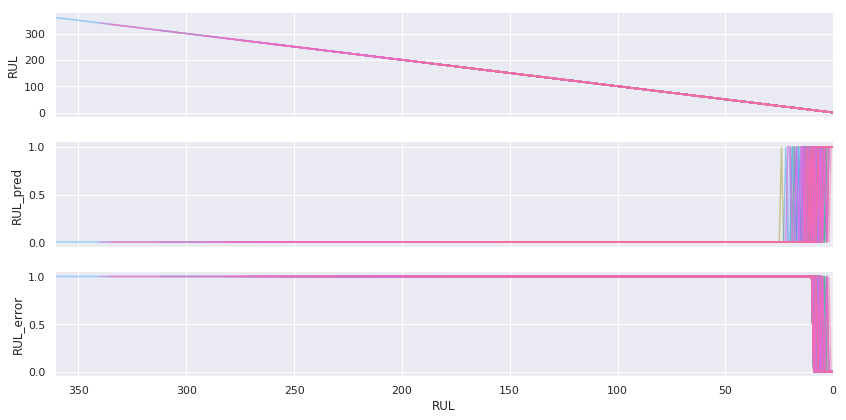

In [103]:
tmp = df_n_train[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_train_cv']
tmp['RUL_pred'] = res['all_full']['y_train_p_cv']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


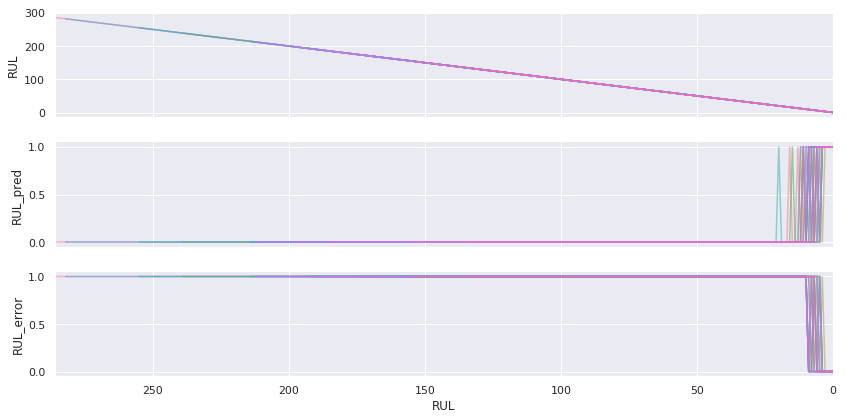

In [104]:
tmp = df_n_test[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_test']
tmp['RUL_pred'] = res['all_full']['y_test_p']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

The predicted RULs are especially off at the beginning of the life cycle of a unit, but seem to get closer the more a machine nears to the end of it's life. This is especially valuable, when it comes to protecting the unit from damage, or scheduling maintenance closely to a breakdown.

Looking at the predicted values it can also be seen, that different machines show differently high predictions 

One way to achieve that, would be to directly model the whole problem as a binary classification problem, another would be to simply thresthold the predicted RUL's by a thresthold value for the RUL. In order to robustify the model further against noise it can make sens to debounce the actual threstholding using a floating median filter.

## Do a quick inspection of a binary threstholding for the test data set results:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(286.0, 0.0)

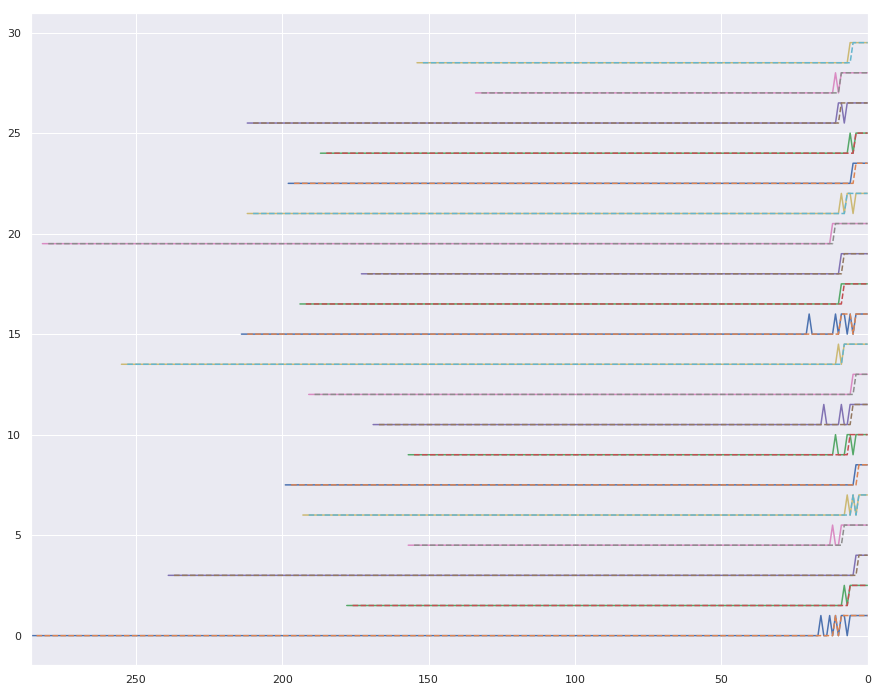

In [105]:
tmp = df_n_test[['RUL', 'unit_nr', 'time', 'FAILURE_NEAR']]
tmp['FAILURE_NEAR_p'] = res['all_full']['y_test_p']

fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
    y = tmp2['FAILURE_NEAR_p'] + (i * 1.5)
    y_med = tmp2['FAILURE_NEAR_p'].rolling(3).median() + (i * 1.5)
     
    ax.plot(tmp2['RUL'].values, y)
    ax.plot(tmp2['RUL'].values, y_med, linestyle='--')
   
ax.set_xlim((df_n_test['RUL'].max(),df_n_test['RUL'].min()))

That looks promising, so lets investigate a bit further.


## Analyze how well a breakdown is detected ahead of time

In [106]:
def map_2_n_looks_ahead(df_loc, res_now, n_ahead = 10):
    tmp = df_loc[['RUL', 'unit_nr', 'time', 'FAILURE_NEAR']]
    tmp['FAILURE_NEAR_p'] = res_now
    df_predictions = {
        'unit_nr': [],
        'FailureFoundAtEnd': [],
        'FailurePredictionError': [],
        'FailureFoundAtEndMedian': [],
        'FailurePredictionErrorMedian': []
    }

    for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
        wind_size = 3
        y = tmp2['FAILURE_NEAR_p'] * 1.0
        y_med = tmp2['FAILURE_NEAR_p'].rolling(wind_size).median()

        RUL_first = n_ahead - tmp2[y > 0].iloc[0]['RUL']
        RUL_first_med = n_ahead - np.ceil(wind_size/2) - tmp2[y_med > 0].iloc[0]['RUL']

        df_predictions['unit_nr'].append(name)
        df_predictions['FailureFoundAtEnd'].append(y.iloc[-1])
        df_predictions['FailurePredictionError'].append(RUL_first)
        df_predictions['FailureFoundAtEndMedian'].append(y_med.iloc[-1])
        df_predictions['FailurePredictionErrorMedian'].append(RUL_first_med)


    df_predictions = pd.DataFrame(df_predictions)
    df_predictions = df_predictions.set_index('unit_nr')
    return df_predictions

## Analyze if unit breakdowns are predicted properly for the cross validated data set

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


units with failure not found at end:
[]
units with failure not found at end (with median):
[]

total number of units where failures are not found properly:
with median   : 0/20 (0.0%)
without median: 0/20 (0.0%)
minimum headsup time for breakdown:
6.0
minimum headsup time for breakdown (with median):
5.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


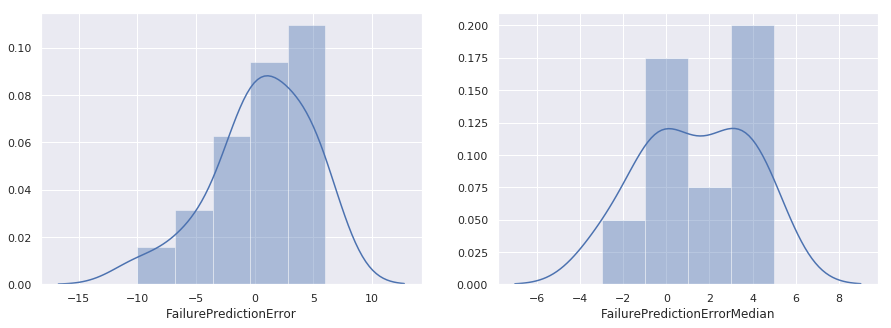

In [107]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_test, res['all_full']['y_test_p'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

print('minimum headsup time for breakdown:')
print(df_predictions['FailurePredictionError'].max())
print('minimum headsup time for breakdown (with median):')
print(df_predictions['FailurePredictionErrorMedian'].max())

## Analyze if unit breakdowns are predicted properly for the testing data set

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


units with failure not found at end:
[]
units with failure not found at end (with median):
[]

total number of units where failures are not found properly:
with median   : 0/80 (0.0%)
without median: 0/80 (0.0%)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


minimum headsup time for breakdown:
6.0
minimum headsup time for breakdown (with median):
6.0


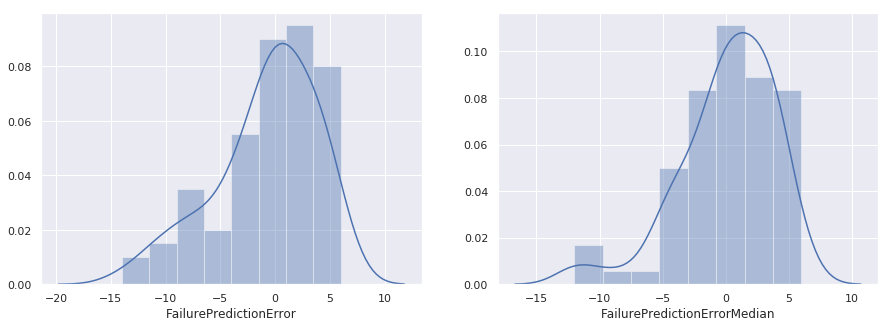

In [108]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_train, res['all_full']['y_train_p_cv'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))
              
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

print('minimum headsup time for breakdown:')
print(df_predictions['FailurePredictionError'].max())
print('minimum headsup time for breakdown (with median):')
print(df_predictions['FailurePredictionErrorMedian'].max())

Numbers > 0 predict a breakdown later than thought, while Numbers < 0 are predicting a breakdown earlier than thought. Values predicting breakdown too early are less problematic than values predicting a breakdown too late. 

Generally it looks like all of the breakdowns are detected at least 5 to 6 cycles ahead of time. With approx 120 to 350 cycles of total life time for the units, these 5 to 6 cycles are approximate 1.5%...4.5% of the units life cycles, which should be enough to schedule proper measures.

The results are from a ML point of view an ok but not necessarily good result. We can do better, but it should be noted, that predicing a breakdown a few cycles before it actually happens already a very practical thing when it comes to building a real condition monitoring systems. Especially considering the fact, that the given SVM model can be implemented very easily.

In [110]:
models = {
    "Linear SVM": SVC(kernel="linear", C=10),
    "RBF SVM": SVC(gamma=2, C=10),
    "Nearest Neighbor": KNeighborsClassifier(3),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Net": MLPClassifier(alpha=1, solver='lbfgs', random_state=0),
    "AdaBoost": AdaBoostClassifier(),
}

res_arr = {}
for name, clf in models.items():
    print('fitting model: ' + name )
    mdl = sk.pipeline.Pipeline([
        ('scaler', sk.preprocessing.MinMaxScaler()),
        ('regression', models[name]),
    ])
    
    res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=mdl, cols_features=None)
    
    res_arr[name] = {
        'res_full': res_full,
        'res_red': res_red,
    }
    
    print('\n=========================\n')

fitting model: Linear SVM
(16627, 14)
cv test accuracy:       0.9836410657364527
testing units accuracy: 0.9855144855144855
(16627, 8)
cv test accuracy:       0.9773260359655981
testing units accuracy: 0.9812687312687313


fitting model: RBF SVM
(16627, 14)
cv test accuracy:       0.9836410657364527
testing units accuracy: 0.9852647352647352
(16627, 8)
cv test accuracy:       0.9768448908401997
testing units accuracy: 0.9815184815184815


fitting model: Nearest Neighbor
(16627, 14)
cv test accuracy:       0.980152763577314
testing units accuracy: 0.981018981018981
(16627, 8)
cv test accuracy:       0.9723341552895892
testing units accuracy: 0.9775224775224776


fitting model: Decision Tree
(16627, 14)
cv test accuracy:       0.9754014554640044
testing units accuracy: 0.973026973026973
(16627, 8)
cv test accuracy:       0.9696878570998978
testing units accuracy: 0.9775224775224776


fitting model: Random Forest
(16627, 14)
cv test accuracy:       0.9788897576231431
testing units accurac

looks like more or less all models converge to the about the same accuracy, so no difference here.